---
# COSC2753 | Machine Learning

## Task 0: Exploratory Data Analysis
---

## Paddy Disease Classification
**meta_train.csv** - The training set

- `image_id` - Unique image identifier corresponds to image file names (.jpg) found in the train_images directory.
- `label` - Type of paddy disease, also the target class. There are ten categories, including the normal leaf.
- `variety` - The name of the paddy variety.
- `age` - Age of the paddy in days.

**train_images** - This directory contains 10,407 training images stored under different sub-directories corresponding to ten target classes. Filename corresponds to the `image_id` column of `meta_train.csv`.

**test_images** - This directory contains 3,469 test set images.

# 1. Introduction

This notebook addresses Task 0 of the Assignment 2: Exploratory Data Analysis of the paddy dataset to better understand the data types, values of each column.

# 2. Library Imports & Setup

This section imports essential libraries and configures global parameters for data exploration and image preprocessing.

In [ ]:
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Reproducible results
np.random.seed(42)

# Misc.
plt.style.use('ggplot')
dir_train_dataset = 'data/train/'
dir_test_dataset = 'data/test/'

# 3. Load Metadata

The metadata file `meta_train.csv` contains image identifiers and their corresponding paddy plant health, variety and age labels. Each image is stored in a subdirectory corresponding to its disease class.

In [3]:
# Load the CSV file
df = pd.read_csv("../data/meta_train.csv")

# Construct full image paths
df["image_path"] = df.apply(
    lambda row: os.path.join("../data/train_images", row["label"], row["image_id"]),
    axis=1,
)

# Basic info
print("Total records:", len(df))
df.head()

Total records: 10407


,image_id,label,variety,age,image_path
0,100330.jpg,bacterial_leaf_blight,ADT45,45,../data/train_images\bacterial_leaf_blight\100...
1,100365.jpg,bacterial_leaf_blight,ADT45,45,../data/train_images\bacterial_leaf_blight\100...
2,100382.jpg,bacterial_leaf_blight,ADT45,45,../data/train_images\bacterial_leaf_blight\100...
3,100632.jpg,bacterial_leaf_blight,ADT45,45,../data/train_images\bacterial_leaf_blight\100...
4,101918.jpg,bacterial_leaf_blight,ADT45,45,../data/train_images\bacterial_leaf_blight\101...


# 4. Exploratory Data Analysis (EDA)

This section investigates the distribution of paddy plant health, variety, age labels and provides visual samples to support preprocessing and model design decisions.

### 4.1 Health Labels Distribution

A bar chart is plotted to examine the overall distribution of plant health labels. This aids in understanding data balance and identifying skewness toward a particular label.

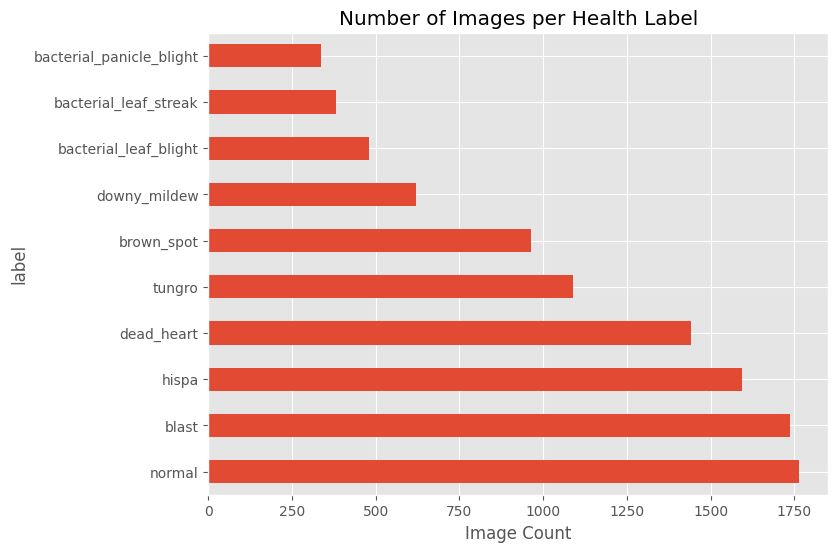

In [5]:
df['label'].value_counts().plot(kind='barh', figsize=(8, 6), title='Number of Images per Health Label')
plt.xlabel('Image Count')
plt.show()

### 4.2 Variety Labels Distribution

A bar chart is plotted to examine the overall distribution of plant variety labels. This aids in understanding data balance and identifying skewness toward a particular label.

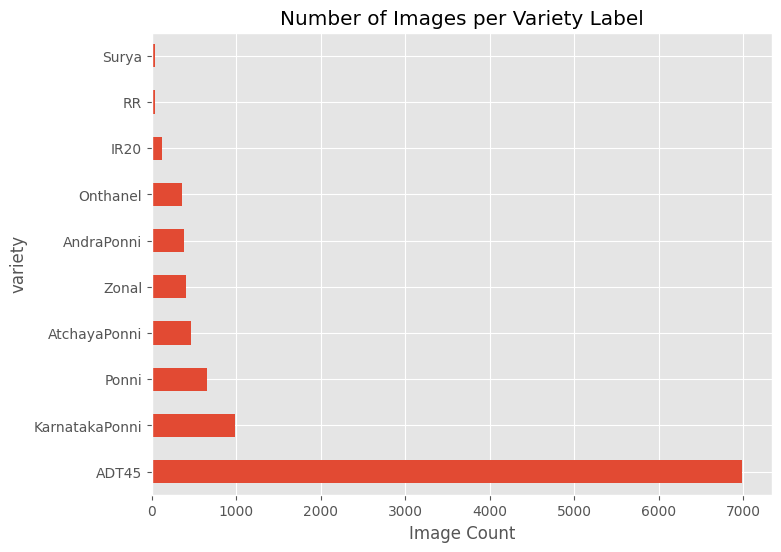

In [6]:
df['variety'].value_counts().plot(kind='barh', figsize=(8, 6), title='Number of Images per Variety Label')
plt.xlabel('Image Count')
plt.show()

### 4.3 Age Distribution

A histogram is plotted to examine the overall distribution of plant ages. This aids in understanding data balance and identifying skewness toward particular age ranges.

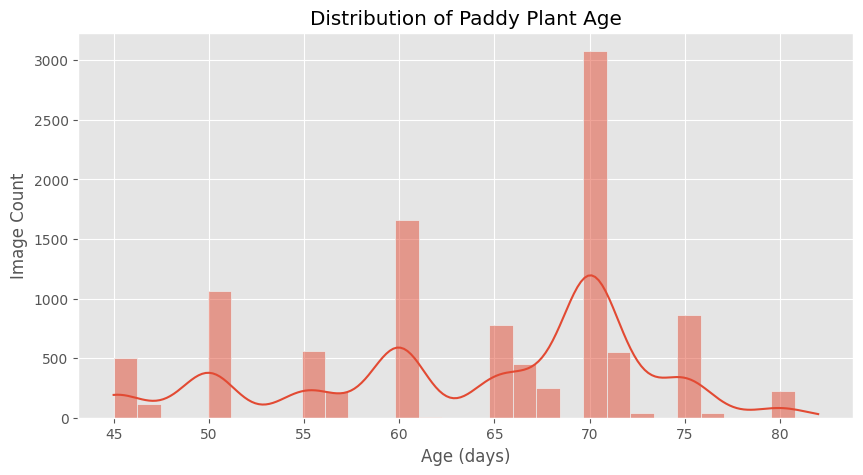

In [9]:
plt.figure(figsize=(10, 5))
sns.histplot(df["age"], bins=30, kde=True)
plt.title("Distribution of Paddy Plant Age")
plt.xlabel("Age (days)")
plt.ylabel("Image Count")
plt.grid(True)
plt.show()

### 4.2 Outlier Detection

A boxplot is used to detect extreme values in the age variable. This visualization supports decisions regarding potential outlier removal or retention.

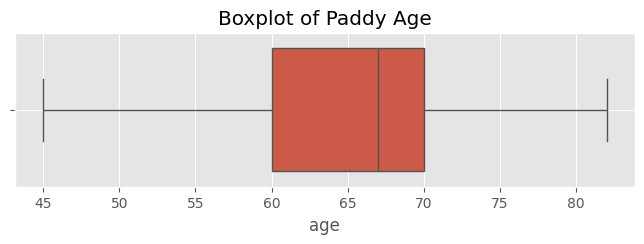

In [10]:
plt.figure(figsize=(8, 2))
sns.boxplot(x=df["age"])
plt.title("Boxplot of Paddy Age")
plt.grid(True)
plt.show()

### 4.3 Visual Inspection of Samples

Sample images from a range of ages are displayed to observe how plant appearance changes according to its health status. Visual cues may later inform convolutional pattern recognition during training.

In [11]:
def data_plot_16samples(df: pd.DataFrame, to_file: str = None):
    sample_indices = np.linspace(0, len(df) - 1, 16).astype(int)

    fig, ax = plt.subplots(4, 4, figsize=(12, 12))
    ax = ax.ravel()

    for i, idx in enumerate(sample_indices):
        row = df.iloc[idx]
        img_path = os.path.normpath(row['image_path'])
    
        ax[i].axis('off')
    
        label = row['label']
        filename = row['image_id']
        ax[i].set_title(f"{label}/{filename}", fontsize=10)
    
        try:
            with Image.open(img_path) as im:
                ax[i].imshow(im)
        except Exception as e:
            ax[i].text(0.5, 0.5, 'Error loading image', ha='center', va='center', fontsize=8)
            print(f"Could not load image {img_path}: {e}")


    plt.tight_layout()
    plt.show()

    if to_file:
        fig.savefig(to_file, bbox_inches='tight')

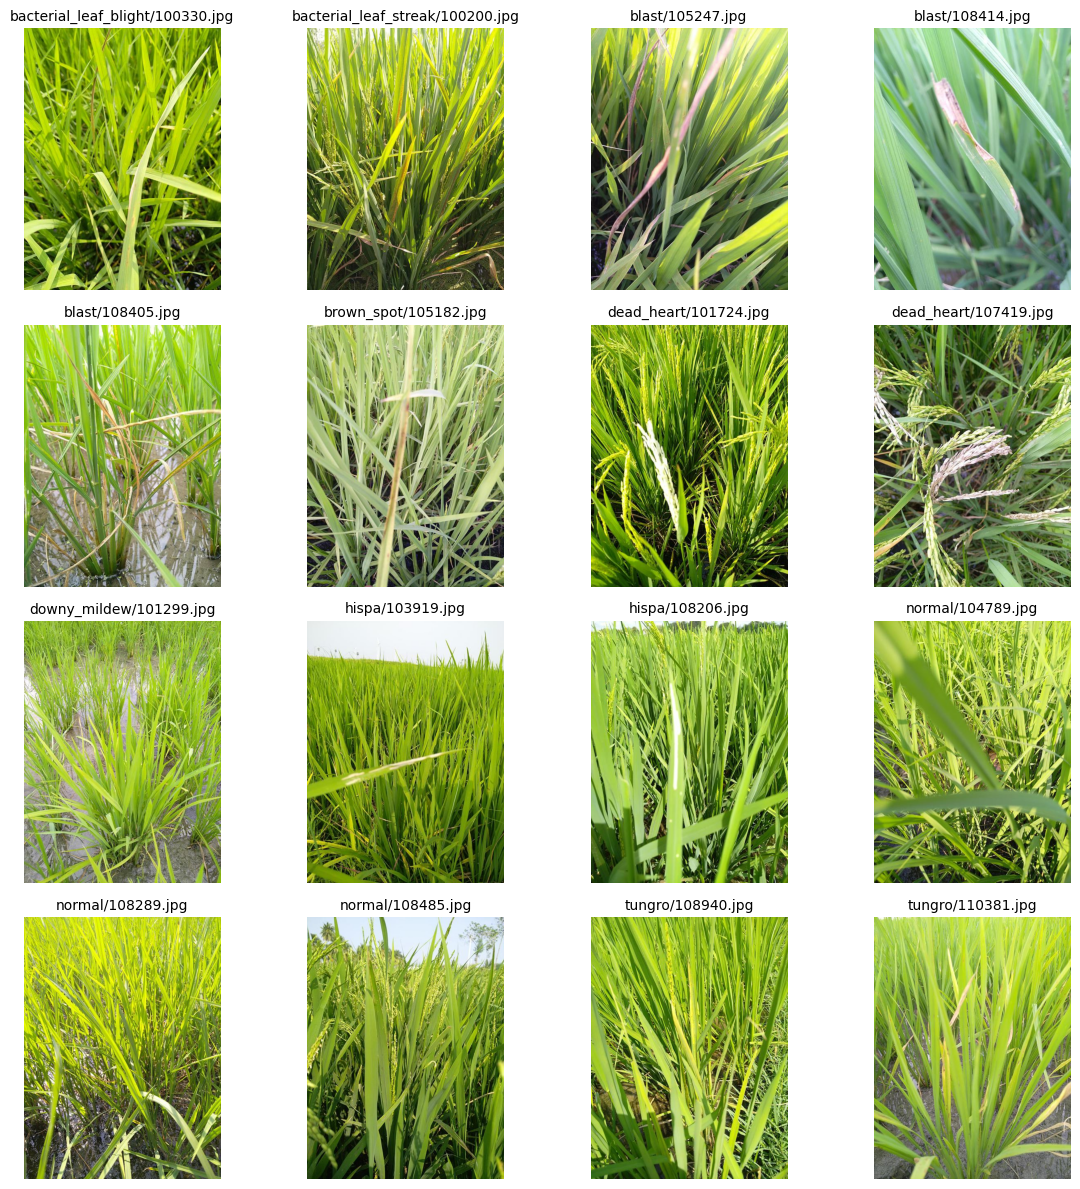

In [12]:
data_plot_16samples(df)

# 5. Data Preprocessing

This section prepares the dataset for model training by applying consistent image transformations and organizing the data into training and validation sets.

All images are resized to 256×256 pixels and normalized to the range [0, 1] as well as removed transparency. Labels are retained as continuous values for supervised regression. Augmentation is applied only to training images during model training to enhance generalization. Preprocessed images are loaded fully into memory to support non-generator-based models such as ANN and DNN.